# Module 6 R Notebook

# Clustering and Pathway Analysis

## Important note - read first

In this course, you are not required to become proficient in writing R scripts for Big Biomedical Data Analytics. The assignments will be based on each module's template, and replacing some parts of them with new data and parameters so that you will get new results and interpret them. 

Understanding all the coding details in R will depend on your bakcground knowledge in programming concepts. 

Therefore if you do not understand all the coding details in R, try to run the code and understand mostly: 

1) what information do I have to provide to this script to make it work ?

2) how to execute this script (it will always be: run the cell containing the script Cell --> Run cells, or click on SHIFT + ENTER at the same time, or simply click on the right arrow icon) ?

3) what results do I get ?

4) how to interpret the results ?

Little by little, you will become familiar with R programming language and, example after example, you will understand the scripts and be ready for more advanced programming work. 

## Assignment goals

In this notebook, you are going to practice clustering and pathway analysis with R scripts.

Here we are continuing to work on a breast cancer dataset downloaded from Firehose (https://gdac.broadinstitute.org/). These are next generation sequencing data that are provided already normalized. 

We are going to compare three clustering methods - K-Means, Pam (K-Means alternative), and dbscan (density-based clustering). We will also perform gene pathway enrichment on the set of genes previously identified for this dataset.

Each time we will reflect on which clustering results is better. These are some the questions we will try and answer.  

So let us get started !

## Preparing the environment

The processes employed to build clustering models use quite a bit of RAM memory, therefore we first allocate this memory by increasaing the program memory size to 3.5GB (= 3,500 MB). We also load some libraries used for analysis - 'cluster' and 'ReactomePA'.

In [1]:
# cell #2
memory.limit(size=3500)
library(cluster)
library(ReactomePA)

Warning message:
: 'memory.limit()' is Windows-specific

[1] Inf

Loading required package: DBI



## Loading the data

We again load the data as we did in modules 3 and 4. We create a dataframe (a spreadsheet) 'mrnaNorm' with the gene expression values and the first column being the gene names. The second dataframe 'mrnaIDs' contains the IDs of the patients. 

In [2]:
# cell #3
mrnaNorm <- read.table("/data/BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt", 
            header = F, fill = T, skip = 2)
mrnaIDs <- read.table("/data/BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt", 
            header = F, fill = T, nrows = 1)
mrnaIDs <- mrnaIDs[, -1][, -1]

## Data preprocessing

'mrnaClass' and 'mrnaClassNum' are created and contain the diagnostic class - 0 for normal and 1 for tumor.

In [3]:
# cell #3
samp <- lapply(as.list(t(mrnaIDs)), function(t) substr(unlist(strsplit(t, "-"))[4], 1, 2))
sampleType <- as.data.frame(samp)
sampClass <- lapply(samp, function(t) (if (t < 10) return("1") else return("0")))
mrnaClass <- as.data.frame(sampClass)
dim(mrnaNorm)
# 20531 1213 columns are patients (except the 1st for gene name) rows are expression levels for each gene
dim(mrnaIDs)
# 1 1213   the first column is the gene name, the others are one patient per row
dim(mrnaClass)
# 1 1212 one patients per row   1 = tumor, 0 = normal
table(unlist(sampClass))
#   0    1 
# 112 1100                     112 normals and 1100 tumor
sampClassNum <- lapply(samp, function(t) (if (t < 10) return(1) else return(0)))
mrnaClassNum <- as.data.frame(sampClassNum) 

[1] 20531  1213

[1]    1 1212

[1]    1 1212


   0    1 
 112 1100 

We also create a dataframe with only the gene names, called 'geneNames', which are located in the first column of 'mrnaNorm', which we extract.

In [4]:
# cell #4
geneNames <- mrnaNorm[1] # extract the gene names from mrnaNorm as its first column
dim(geneNames)
# 20531 genes

[1] 20531     1

next we transpose the 'mrnaNorm' dataframe because we want to select genes, therefore they have to be represented in columns instead of rows. We also remove the first column of 'mrnaNorm' since it contains the gene names.
Because we are working with large datasets, we free space from memory by removing the objects we will not be using anymore. 'gc' garbage collects the free space, which will leave more space for building the models. The column 'used' and right after it '(Mb)' indicates the memory in use.

In [5]:
# cell #5
mrnaData = t(mrnaNorm[, -1]) # remove first column of mrnaData and transpose it to have genes as columns
rm(samp)
rm(sampClass)
rm(mrnaNorm)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1640070.0,87.6,7394720.0,395.0,9147377.0,488.6
Vcells,31037398.0,236.8,97244039.0,742.0,80839180.0,616.8


## Feature selection with bss/wss

Again, we select top genes with bss/wss. First we load the bssWssFast function.

In [8]:
# cell #6
bssWssFast <- function (X, givenClassArr, numClass=2)
# between squares / within square feature selection
{
	classVec <- matrix(0, numClass, length(givenClassArr))
	for (k in 1:numClass) {
		temp <- rep(0, length(givenClassArr))
		temp[givenClassArr == (k - 1)] <- 1
		classVec[k, ] <- temp
	}
	classMeanArr <- rep(0, numClass)
	ratio <- rep(0, ncol(X))
	for (j in 1:ncol(X)) {
		overallMean <- sum(X[, j]) / length(X[, j])
		for (k in 1:numClass) {
			classMeanArr[k] <- 
				sum(classVec[k, ] * X[, j]) / sum(classVec[k, ])
		}
	  classMeanVec <- classMeanArr[givenClassArr + 1]
	  bss <- sum((classMeanVec - overallMean)^2)
	  wss <- sum((X[, j] - classMeanVec)^2)
	  ratio[j] <- bss/wss
	}
      sort(ratio, decreasing = TRUE, index = TRUE)
}

Then we again run 'bssWssFast' on our large dataset to rank the features within and across classes. We work from mrnaData, which is the transposed datafrom from 'mrnaNorm' dataframe because we want to select genes, therefore they have to be represented in columns instead of rows. 

We select the top 100 genes and create a subset of 'mrnaData' with these genes, called 'mrnaDataReduced'. This dataset has 1212 patients and 100 genes.

We store the class in trainClasses.

In [9]:
# cell #7
# select features
dim(mrnaData)
# 1212 20531  matrix
dim(mrnaClass)
# 1 1212
dim(mrnaClassNum)
# 1 1212
dim(geneNames)
# 20531 genes
bss <- bssWssFast(mrnaData, t(mrnaClassNum), 2)
mrnaDataReduced <- mrnaData[,bss$ix[1:100]]
dim(mrnaDataReduced)
# 1212  100
trainClasses <- unlist(mrnaClassNum[1,], use.names=FALSE)

[1]  1212 20531

[1]    1 1212

[1]    1 1212

[1] 20531     1

[1] 1212  100

## Clustering with KMeans

We are going to find clusters with KMeans. Remember that this algorithm takes as input a number of clusters we want to find. Here we set this number to two - it makes sense wince we would like optimally that the normals and the tumor samples be placed in two different clusters. We set the random seed to a fixed number so that each time we run the algorithm, we get same results.

We also look at the results and find that the two clusters have 13 and 1199 samples. 13 is far from the optimal number of 112 in the normal set.

In [10]:
# cell #8
set.seed(20)
kmeans.clusters <- kmeans(mrnaDataReduced, 2, nstart = 20)
table(kmeans.clusters$cluster)


   1    2 
  13 1199 

Let us look how well this clustering matches our classes of 0 and 1. We can do this using 'table'.

We can see that all the 1's are in the same - large - cluster. However there are 99 of 0's clustered in the same group as the 1's.

In [11]:
# cell #9
table(kmeans.clusters$cluster, trainClasses)

   trainClasses
       0    1
  1   13    0
  2   99 1100

We can also plot the results and see the intersection between the two clusters. We also see that the clusters are ellipsoid or circular, which is probably why the results ae not perfect. 

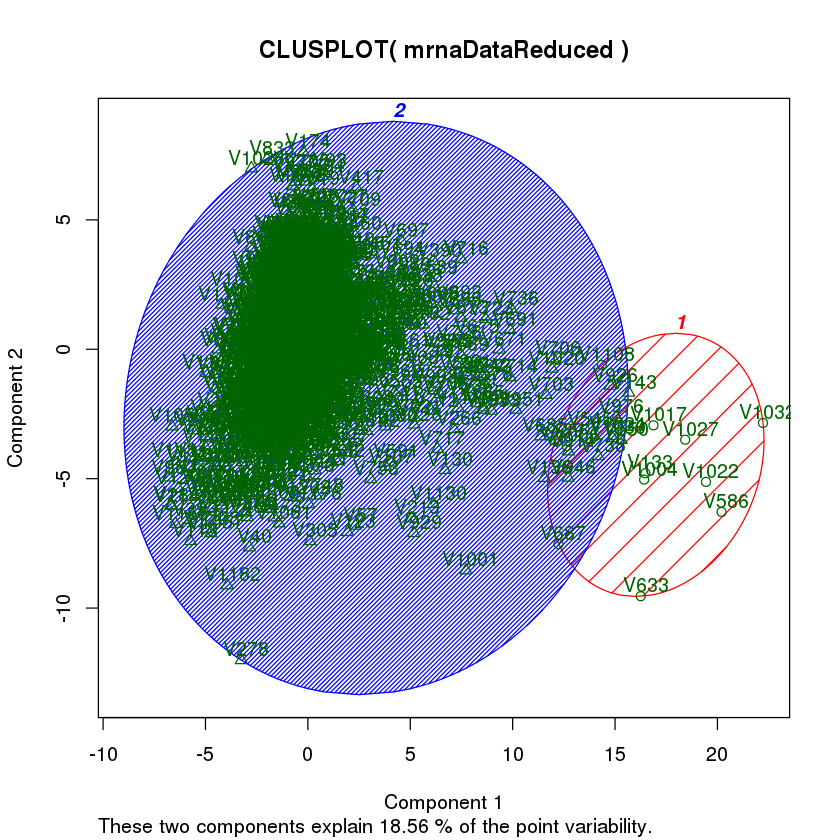

In [12]:
# cell #10
clusplot(mrnaDataReduced, kmeans.clusters$cluster, color=TRUE, shade=TRUE, 
  	labels=2, lines=0)

## Clustering with Pam

We are going to find clusters with Pam, which is an improvement over KMeans. Here as well it makes sense wince we would like optimally that the normals and the tumor samples be placed in two different clusters. 

We also look at the results and find that the two clusters have 36 and 1176 samples. 36 is far from the optimal number of 112 in the normal set, however it is better than the 13 of KMeans.

In [13]:
# cell #11
pam.clusters <- pam(mrnaDataReduced, 2)
table(pam.clusters$clustering)


   1    2 
1176   36 

Let us look how well this clustering matches our classes of 0 and 1. We can do this using 'table'.

We can see that all the 1's are in the same - large - cluster. However there are 76 of 0's clustered in the same group as the 1's.

In [14]:
# cell #12
table(pam.clusters$clustering, trainClasses)

   trainClasses
       0    1
  1   76 1100
  2   36    0

We can also plot the results and see the intersection between the two clusters. We also see that the clusters are ellipsoid or convex, which is probably why the results ae not perfect. 

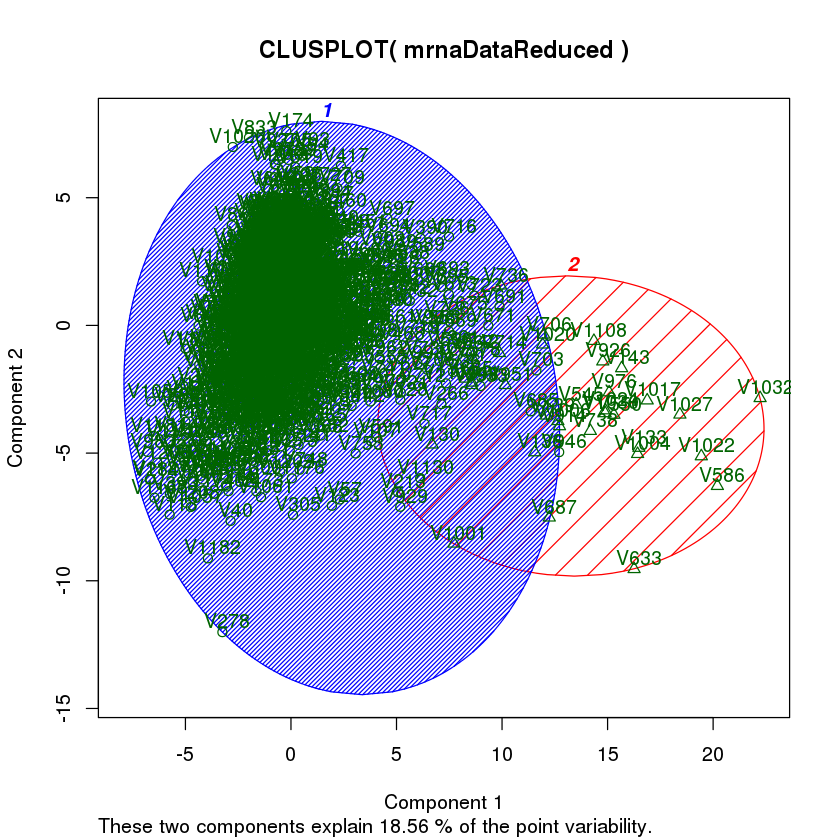

In [15]:
# cell #13
clusplot(mrnaDataReduced, pam.clusters$clustering, color=TRUE, shade=TRUE, 
  	labels=2, lines=0)

In conclusion we can say that Pam performs better at grouping the 0's and 1's in different clustres. However the ellipsoid shape of the clusters limits the ability to separate the two classes. We see in this example that other methods would be good to try - such as density based clustering or agglomerative clustering.

## Pathway analysis

We are going to find pathways associated with the genes selected by bssWssFast. We have 100 of these genes, whose names are stored in geneNames.

First we extract the gene names from the gene indexes provided by bss$ix.
We make sure that the gene names are character strings (words).

Remember that the genes are provided in TCGA by the hugo+code|entrez_code. Therefore we want to separate the two and split the name into hugo name and entrez name. 

We then pass the list of genes Entrez codes into 'enrichPathway' from 'ReactomePA' package. ReactomePA searches the reactome pathway database for pathways having these genes somewhere along their paths.  

We then display the first 6 lines of 'paths'. There are 5 pathways matched by our genes, as we can see related to eNOS, nitric oxyde etc.



In [16]:
# cell #14
genes <- geneNames[bss$ix[1:100],1]
genes <- as.character(genes)
hugoNames <- lapply(genes, function(t) substr(t, 1, regexpr("\\|", t) - 1))   # extract HUGO names
entrezNames <- lapply(genes, function(t) substr(t, regexpr("\\|", t) + 1, nchar(t)))  # extract Entrez names
paths = enrichPathway(unlist(entrezNames), pvalueCutoff=1)
head(summary(paths))

Loading required package: org.Hs.eg.db
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: Bioba

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
203615,203615,eNOS activation,2/33,10/6750,0.001017856,0.1313035,0.1199999,857/10434,2
202131,202131,Metabolism of nitric oxide,2/33,20/6750,0.004168235,0.1344256,0.1228532,857/10434,2
202427,202427,Phosphorylation of CD3 and TCR zeta chains,2/33,20/6750,0.004168235,0.1344256,0.1228532,55824/3115,2
203765,203765,eNOS activation and regulation,2/33,20/6750,0.004168235,0.1344256,0.1228532,857/10434,2
3299685,3299685,Detoxification of Reactive Oxygen Species,2/33,28/6750,0.008092767,0.2087934,0.1908189,847/6647,2


You can also visualize the results in several different ways.

In [ ]:
# cell #15
enrichMap(paths, layout=igraph::layout.kamada.kawai, vertex.label.cex = 1)